In [ ]:
import random
import numpy as np
import math 
from random import choice
import statistics 
import matplotlib.pyplot as plt

In [ ]:
startingSudoku = """
                    024007000
                    600000000
                    003680415
                    431005000
                    500000032
                    790000060
                    209710800
                    040093000
                    310004750
                """
# startingSudoku = """
#                       000000680
#                       000073009
#                       309000045
#                       490000000
#                       803050902
#                       000000036
#                       960000308
#                       700680000
#                       028000000
#                 """
sudoku = np.array([[int(i) for i in line] for line in startingSudoku.split()])
costarray=[]

In [ ]:
def PrintSudoku(sudoku):
    print("\n")
    for i in range(len(sudoku)):
        line = ""
        if i == 3 or i == 6:
            print("---------------------")
        for j in range(len(sudoku[i])):
            if j == 3 or j == 6:
                line += "| "
            line += str(sudoku[i,j])+" "
        print(line)


In [ ]:
def FixSudokuValues(fixed_sudoku):
    for i in range (0,9):
        for j in range (0,9):
            if fixed_sudoku[i,j] != 0:
                fixed_sudoku[i,j] = 1
    
    return(fixed_sudoku)


In [ ]:
def CalculateNumberOfErrors(sudoku):
    numberOfErrors = 0 
    for i in range (0,9):
        numberOfErrors += CalculateNumberOfErrorsRowColumn(i ,i ,sudoku)
    return(numberOfErrors)


In [ ]:
def CalculateNumberOfErrorsRowColumn(row, column, sudoku):
    numberOfErrors = (9 - len(np.unique(sudoku[:,column]))) + (9 - len(np.unique(sudoku[row,:])))
    return(numberOfErrors)



In [ ]:
def CreateList3x3Blocks ():
    finalListOfBlocks = []
    for r in range (0,9):
        tmpList = []
        block1 = [i + 3*((r)%3) for i in range(0,3)]
        block2 = [i + 3*math.trunc((r)/3) for i in range(0,3)]
        # print("block1=")
        # print(block1)

        # print("block2=")
        # print(block2)
        for x in block1:
            for y in block2:
                tmpList.append([x,y])
        finalListOfBlocks.append(tmpList)
    # print(finalListOfBlocks)
    return(finalListOfBlocks)


In [ ]:
def RandomlyFill3x3Blocks(sudoku, listOfBlocks):
    for block in listOfBlocks:
        for box in block:
            if sudoku[box[0],box[1]] == 0:
                currentBlock = sudoku[block[0][0]:(block[-1][0]+1),block[0][1]:(block[-1][1]+1)]
                # print(currentBlock)
                sudoku[box[0],box[1]] = choice([i for i in range(1,10) if i not in currentBlock])
    return sudoku


In [ ]:
def SumOfOneBlock (sudoku, oneBlock):
    finalSum = 0
    for box in oneBlock:
        finalSum += sudoku[box[0], box[1]]
    return(finalSum)


In [ ]:
def TwoRandomBoxesWithinBlock(fixedSudoku, block):
    while (1):
        firstBox = random.choice(block)
        secondBox = choice([box for box in block if box is not firstBox ])

        if fixedSudoku[firstBox[0], firstBox[1]] != 1 and fixedSudoku[secondBox[0], secondBox[1]] != 1:
            return([firstBox, secondBox])


In [ ]:
def FlipBoxes(sudoku, boxesToFlip):
    proposedSudoku = np.copy(sudoku)
    placeHolder = proposedSudoku[boxesToFlip[0][0], boxesToFlip[0][1]]
    proposedSudoku[boxesToFlip[0][0], boxesToFlip[0][1]] = proposedSudoku[boxesToFlip[1][0], boxesToFlip[1][1]]
    proposedSudoku[boxesToFlip[1][0], boxesToFlip[1][1]] = placeHolder
    return (proposedSudoku)


In [ ]:
def ProposedState (sudoku, fixedSudoku, listOfBlocks):
    randomBlock = random.choice(listOfBlocks)

    if SumOfOneBlock(fixedSudoku, randomBlock) > 7:  
        return(sudoku, 1, 1)
    boxesToFlip = TwoRandomBoxesWithinBlock(fixedSudoku, randomBlock)
    proposedSudoku = FlipBoxes(sudoku,  boxesToFlip)
    return([proposedSudoku, boxesToFlip])


In [ ]:
def ChooseNewState (currentSudoku, fixedSudoku, listOfBlocks, sigma):
    proposal = ProposedState(currentSudoku, fixedSudoku, listOfBlocks)
    newSudoku = proposal[0]         
    boxesToCheck = proposal[1]      
    currentCost = CalculateNumberOfErrorsRowColumn(boxesToCheck[0][0], boxesToCheck[0][1], currentSudoku) + CalculateNumberOfErrorsRowColumn(boxesToCheck[1][0], boxesToCheck[1][1], currentSudoku)
    newCost = CalculateNumberOfErrorsRowColumn(boxesToCheck[0][0], boxesToCheck[0][1], newSudoku) + CalculateNumberOfErrorsRowColumn(boxesToCheck[1][0], boxesToCheck[1][1], newSudoku)
    costDifference = newCost - currentCost
    rho = math.exp(-costDifference/sigma)
    if(np.random.uniform(1,0,1) < rho):
        return([newSudoku, costDifference])
    return([currentSudoku, 0])    
                                

In [ ]:

def ChooseNumberOfItterations(fixed_sudoku):
    numberOfItterations = 0
    for i in range (0,9):
        for j in range (0,9):
            if fixed_sudoku[i,j] != 0:
                numberOfItterations += 1
    return numberOfItterations


In [ ]:
def CalculateInitialSigma (sudoku, fixedSudoku, listOfBlocks):
    listOfDifferences = []
    tmpSudoku = sudoku
    for i in range(1,10):
        tmpSudoku = ProposedState(tmpSudoku, fixedSudoku, listOfBlocks)[0]
        listOfDifferences.append(CalculateNumberOfErrors(tmpSudoku))
    return (statistics.pstdev(listOfDifferences))


In [ ]:
def solveSudoku (sudoku):
    f = open("demofile2.txt", "a")
    solutionFound = 0
    while (solutionFound == 0):
        decreaseFactor = 0.98
        stuckCount = 0
        fixedSudoku = np.copy(sudoku)
        PrintSudoku(sudoku)
        FixSudokuValues(fixedSudoku)
        listOfBlocks = CreateList3x3Blocks()
        tmpSudoku = RandomlyFill3x3Blocks(sudoku, listOfBlocks)
        sigma = CalculateInitialSigma(sudoku, fixedSudoku, listOfBlocks)
        score = CalculateNumberOfErrors(tmpSudoku)
        itterations = ChooseNumberOfItterations(fixedSudoku)
        if score <= 0:
            solutionFound = 1

        while solutionFound == 0:
            previousScore = score
            for i in range (0, itterations):
                newState = ChooseNewState(tmpSudoku, fixedSudoku, listOfBlocks, sigma)
                tmpSudoku = newState[0]
                scoreDiff = newState[1]
                score += scoreDiff
                # print(score)
                costarray.append(score)
                f.write(str(score) + '\n')
                if score <= 0:
                    solutionFound = 1
                    break

            sigma *= decreaseFactor
            if score <= 0:
                solutionFound = 1
                break
            if score >= previousScore:
                stuckCount += 1
            else:
                stuckCount = 0
            if (stuckCount > 80):
                sigma += 2
            if(CalculateNumberOfErrors(tmpSudoku)==0):
                PrintSudoku(tmpSudoku)
                break
    f.close()
    return(tmpSudoku)




0 2 4 | 0 0 7 | 0 0 0 
6 0 0 | 0 0 0 | 0 0 0 
0 0 3 | 6 8 0 | 4 1 5 
---------------------
4 3 1 | 0 0 5 | 0 0 0 
5 0 0 | 0 0 0 | 0 3 2 
7 9 0 | 0 0 0 | 0 6 0 
---------------------
2 0 9 | 7 1 0 | 8 0 0 
0 4 0 | 0 9 3 | 0 0 0 
3 1 0 | 0 0 4 | 7 5 0 


1 2 4 | 9 5 7 | 3 8 6 
6 8 5 | 3 4 1 | 2 9 7 
9 7 3 | 6 8 2 | 4 1 5 
---------------------
4 3 1 | 2 6 5 | 9 7 8 
5 6 8 | 4 7 9 | 1 3 2 
7 9 2 | 1 3 8 | 5 6 4 
---------------------
2 5 9 | 7 1 6 | 8 4 3 
8 4 7 | 5 9 3 | 6 2 1 
3 1 6 | 8 2 4 | 7 5 9 


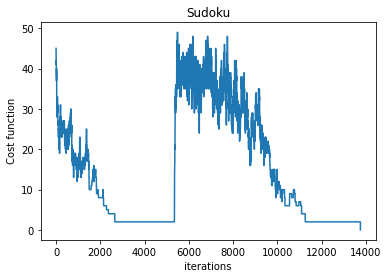

In [ ]:
solution = solveSudoku(sudoku)
# print(CalculateNumberOfErrors(solution))
# print(costarray)
x=np.arange(0,len(costarray))
plt.plot(x,costarray)

plt.xlabel('iterations')
plt.ylabel(' Cost function')
  
# displaying the title
plt.title("Sudoku")
PrintSudoku(solution)